This is a test for the python interface to particle local coordinates. 

We generate a regular mesh with swarm, then deform the mesh, then try and re-set the particles within the mesh via the local coordintes.

In [1]:
import underworld as uw
import underworld.visualisation as vis
import numpy as np
import math


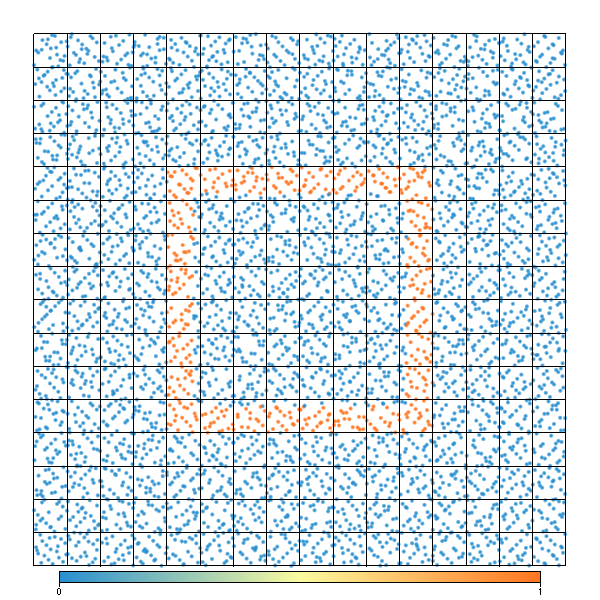

In [2]:
# giordani mesh 
minCoord = [-1.,-1.]
maxCoord = [ 1., 1.]
mesh = uw.mesh.FeMesh_Cartesian( elementRes=(16,16), minCoord=minCoord, maxCoord=maxCoord)
def circleMesh(mesh):
    with mesh.deform_mesh():
        for vert in mesh.data[:]:
            radius = np.max(np.abs(vert))
            angle = np.arctan2(vert[1],vert[0])
            vert[0] = radius*math.cos(angle)
            vert[1] = radius*math.sin(angle)
        with swarm.deform_swarm():
            swarm.particleCoordinates.data[:] = uw.function.input().evaluate(picswarm)



# check.. note we need to use a lower tolerance for the q1 mesh because it always 
# under-integrates due to the mesh 'cutting corners'
swarm = uw.swarm.Swarm(mesh)
svar = swarm.add_variable('int',1)
swarm.populate_using_layout(uw.swarm.layouts.PerCellSpaceFillerLayout(swarm,20))
svar.data[:]=0

for index,coord in enumerate(swarm.particleCoordinates.data):
    if (abs(coord[0])>0.4) or (abs(coord[1])>0.4):
        if (abs(coord[0])<0.5) and (abs(coord[1])<0.5):
            svar.data[index]=1


meshfig = vis.Figure(figsize=(600,600))
meshfig.append( vis.objects.Mesh(mesh) )
meshfig.append( vis.objects.Points(swarm, svar, pointSize=5) )
# lets also create the PICswarm
picswarm = uw.swarm.VoronoiIntegrationSwarm(swarm)
picswarm.repopulate()

meshfig.show()

In [3]:
def max_radius(partCoords):
    coord2 = np.inner(partCoords,partCoords)
    return math.sqrt(coord2.max())
if not np.isclose( max_radius(swarm.particleCoordinates.data), math.sqrt(2), rtol=2e-2 ):
    raise RuntimeError("Particles should have a max radius of sqrt(2) at this point.")


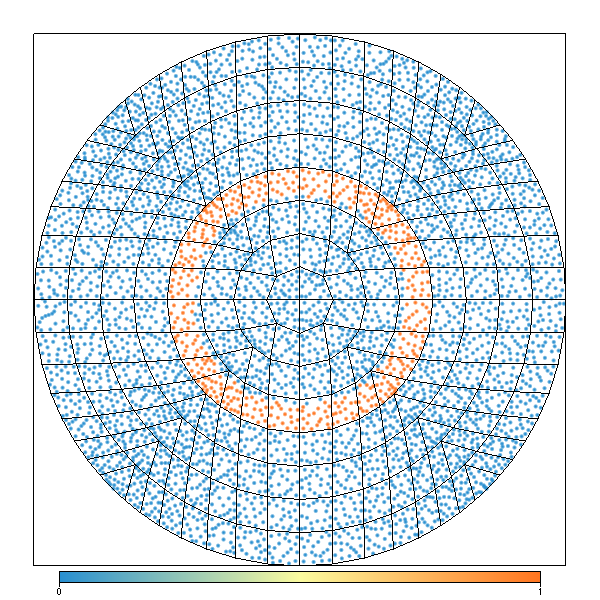

In [4]:
circleMesh(mesh)
meshfig.show()

In [5]:
if not np.isclose( max_radius(swarm.particleCoordinates.data), math.sqrt(1), rtol=1e-2 ):
    raise RuntimeError("Particles should have a max radious of sqrt(1) at this point.")

In [6]:
velfield = mesh.add_variable(2)
presfield = mesh.subMesh.add_variable(1)

In [7]:
allwalls = mesh.specialSets['AllWalls_VertexSet']
bc = uw.conditions.DirichletCondition(velfield,indexSetsPerDof=(allwalls,allwalls))
density = swarm.add_variable('double',1)

In [8]:
sys = uw.systems.Stokes(velfield,presfield,1.,(0.,-density),  conditions=bc)

In [9]:
density.data[:] = 0.
for index,coord in enumerate(swarm.particleCoordinates.data):
    if (coord[1]>0.) and  (coord[0]>0.):
        density.data[index] = 1.

In [10]:
fig = vis.Figure()



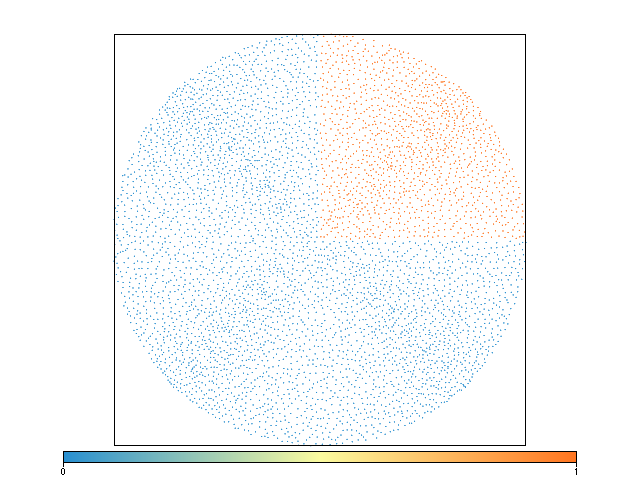

In [11]:
fig.append(vis.objects.Points(swarm,density,pointSize=2.))
fig.show()

In [12]:
solver = uw.systems.Solver(sys)
solver.solve()


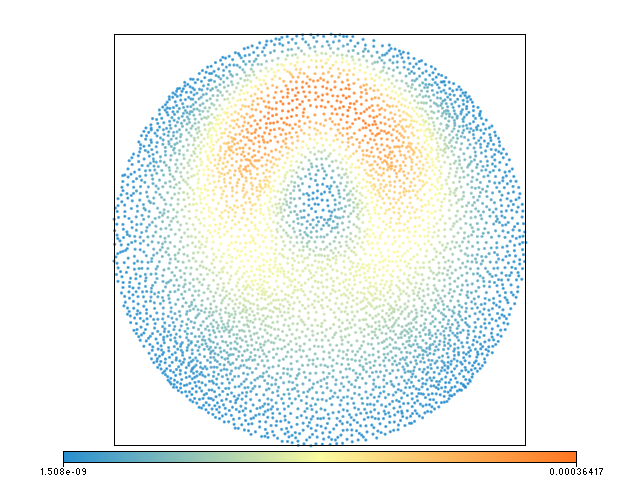

In [13]:
fig = vis.Figure()
fig.append(vis.objects.Points(swarm,uw.function.math.dot(velfield,velfield),pointSize=4.))
fig.show()

In [14]:
if not np.isclose( sys.velocity_rms(), 0.0104, rtol=1e-3 ):
    raise RuntimeError("VRMS velocity not as expected.")